In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
from tqdm import tqdm
import time
import pickle
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from scipy.stats import sem

from lifelines import KaplanMeierFitter

from bl_results_plots import km_plots, km_calculate, stats_plot, km_calculateB

In [3]:
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, roc_curve, plot_confusion_matrix, f1_score, recall_score, accuracy_score

from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve

# 1 year predictions

/condor_data/sgcwhitl/Bayesian/results/New/1yeardeath_0607_1yd_norm_20test_hotelling_frac1.0_H_indices_100its_5pca_dir_1000samps

# 1 year predictions no asma

/condor_data/sgcwhitl/Bayesian/results/New/1yeardeath_1607_noasma_8pca

# 2 year predictions

/condor_data/sgcwhitl/Bayesian/results/New/2year_2807_2year_asma_re_run

# 2 year predictions no asma

/condor_data/sgcwhitl/Bayesian/results/New/2year_1607_noasma_8pca

In [30]:
FN = '/condor_data/sgcwhitl/Bayesian/results/New/2year_2807_2year_asma_re_run'

save_name = '2_year_predictions_asma'

pickle_results = dict()

metadata = pd.read_csv('./metadata.csv').iloc[:,2:]


In [31]:
y_tests = []
blr_posteriors = []
lr_preds = []

In [32]:
samples = []

for i, hdf_name in enumerate(tqdm(glob.glob(FN + '**/**/*.hdf')[:])):

    sample_dict = dict()

    for pred_name in ['y_test', 'BLR_Posterior', 'LR_Preds']:

        sample_dict[pred_name] = pd.read_hdf(hdf_name, key=pred_name).astype(np.float16).reset_index('REF').reset_index(drop=True).set_index('REF')

    #samples.append(pd.concat(sample_dict, axis=1))
    samples.append(pd.concat(sample_dict,axis=1))

in_results = pd.concat(dict(enumerate(samples)))

100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


In [33]:
in_results.index = in_results.index.set_names('Split', level=0)

metadata_index = in_results.copy().index.to_frame().reset_index(drop=True).merge(metadata.query('TMA in [1,2]'), on = 'REF', how='left')

#results.index = 


In [34]:
results = pd.DataFrame(in_results.values, columns=in_results.columns, index= pd.MultiIndex.from_frame(metadata_index)) 

results_dict_fn = glob.glob(FN + '**/*.pickle')[0]

with open(results_dict_fn, 'rb') as file_:

    results_dict = pickle.load(file_)

# Bayesian Logistic Regression

In [35]:
ts = np.linspace(0.2, 0.9, 10)

F1 = pd.DataFrame([{t: f1_score(y_true=row.xs('y_test', axis=1, level=0), y_pred=row.xs('BLR_Posterior', axis=1, level=0).mean(axis=1)>t) for t in ts} for i, row in tqdm(results.groupby('Split'))])
F1_accept = F1.index[~(F1==0).any(axis=1)]


100%|██████████| 100/100 [07:29<00:00,  4.50s/it]


In [36]:
print(F1.shape, len(F1_accept))

(100, 10) 94


{'AUC': 'A', 'MCC': 'B', 'Specificity': 'C', 'Sensitivity': 'D', 'PPV': 'E', 'NPV': 'F'}
Plots saved in ./plots/2year_2807_2year_asma


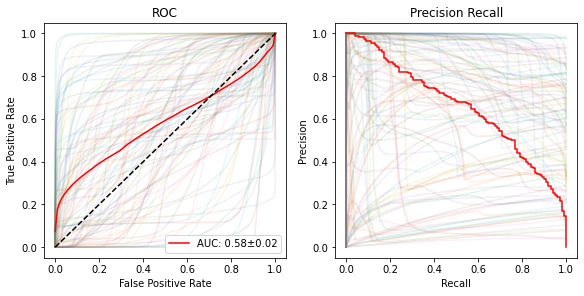

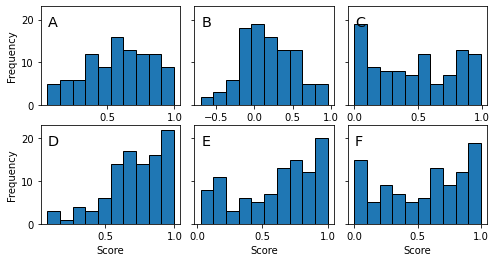

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (8,4), constrained_layout = True)

stats = {'AUC':[]
        ,'MCC':[]
        ,'Specificity':[]
        ,'Sensitivity':[]
        ,'PPV':[]
        ,'NPV':[]}

roc_curves = []
prec_rec_curves = []
threshs = []


#for idx, row in results.query(f'Split in {list(F1_accept)}').groupby('Split'):
for idx, row in results.groupby('Split'):
#for idx, row in results.groupby('Split'):

    probs = row.xs('BLR_Posterior', axis=1, level=0).mean(axis=1)
    true = row.xs('y_test', axis=1, level=0)

    if len(np.unique(true)) == 1: continue

    ts = np.linspace(0.2,0.9,20)

    f1 = pd.Series({t: f1_score(y_true=true, y_pred=probs>t) for t in ts})
    best_threshold = f1.idxmax()

    preds = np.array([1 if el > best_threshold else 0 for el in probs])

    fpr, tpr, thresh = roc_curve(true, probs);
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, alpha=0.1)

    roc_curves.append(np.interp(np.linspace(0,1,100), fpr, tpr))

    #ax2.plot(fpr_u, tpr_u, label='unweighted')
    ax1.set_title("ROC")

    prec, recall, _ = precision_recall_curve(true, probs)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, alpha=0.1)
    ax2.set_title("Precision Recall")
    prec_rec_curves.append(np.interp(np.linspace(0,1,100), prec, recall))

    cm = confusion_matrix(true, preds)
    tn, fp, fn, tp = cm.flatten()

    stats['AUC'].append(roc_auc_score(true, probs))
    #stats['F1'].append(f1_score(y_true=true, y_pred=preds))
    stats['MCC'].append(((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    stats['Specificity'].append(tn/(tn+fp))
    stats['Sensitivity'].append(tp/(tp+fn))
    stats['PPV'].append(tp/(tp+fp))
    stats['NPV'].append(tn/(tn+fn))

    threshs.append(best_threshold)

roc_curves=np.array(roc_curves)
prec_rec_curves=np.array(prec_rec_curves)

#fpr_w, tpr_w, thresh_w = roc_curve(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values));
#auc = roc_auc_score(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values))
RocCurveDisplay(fpr=np.linspace(0,1,100), tpr=np.nanmean(roc_curves, axis=0)).plot(ax=ax1, color='r', label=f"AUC: {np.mean(stats['AUC']):.2f}±{sem(stats['AUC']):.2f}")
ax1.plot([0,1],[0,1], ls='--', c='black')

if not os.path.exists(f"./plots/{FN.split('/')[-1][:-7]}/BLR"):

    os.makedirs(f"./plots/{FN.split('/')[-1][:-7]}/BLR")

PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')
plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/BLR/roc_prec.pdf", bbox_inches='tight')

stats_plot(pd.DataFrame(stats))

#axes = pd.DataFrame(stats).hist(figsize=(12,7), layout=(2,3), sharey = True, w_pad=0, wspace=0);
#[ax.set_ylabel('Frequency') for ax in axes.flatten()]
#[ax.set_xlabel('Score') for ax in axes.flatten()]

plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/BLR/stats.pdf", bbox_inches='tight')
print(f'Plots saved in ./plots/{FN.split("/")[-1][:-7]}')


In [42]:
tsi, fsi, ps = km_calculateB(results.query(f'Split in {list(F1_accept)}'), 'survival (months)', 'BLR_Posterior', 'DiedvsAlive')


(94, 2)


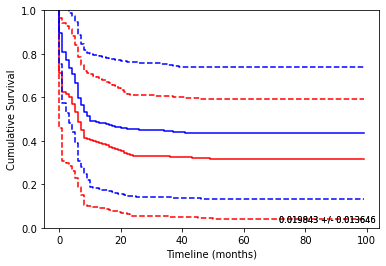

In [43]:
fig = km_plots(tsi, fsi, ps);

In [44]:
pickle_results['Bayesian LR'] = {'ROC Curves': roc_curves
                               , 'PR Curves': prec_rec_curves
                               , 'Stats': stats
                               , 'TSI': tsi
                               , 'FSI': fsi
                               , 'Survival_P': ps}


# Logistic Regression

In [24]:
ts = np.linspace(0.2, 0.9, 10)

F1 = pd.DataFrame([{t: f1_score(y_true=row.xs('y_test', axis=1, level=0), y_pred=row.xs('LR_Preds', axis=1, level=0).iloc[:,1]>t) for t in ts} for i, row in tqdm(results.groupby('Split'))])
F1_accept = F1.index[~(F1==0).any(axis=1)]


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


{'AUC': 'A', 'MCC': 'B', 'Specificity': 'C', 'Sensitivity': 'D', 'PPV': 'E', 'NPV': 'F'}
 plots saved in ./plots/2year_2807_2year_asma/LR/stats.pdf


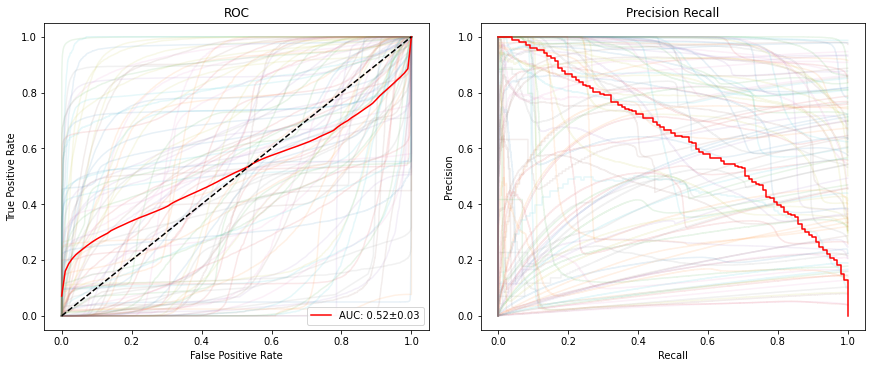

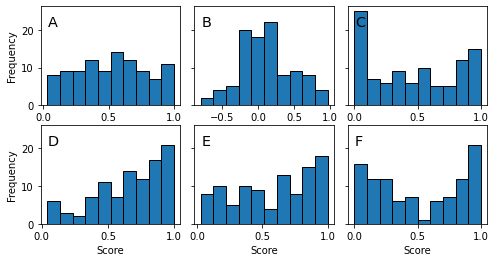

In [49]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,5), constrained_layout = True)

stats = {'AUC':[]
        ,'MCC':[]
        ,'Specificity':[]
        ,'Sensitivity':[]
        ,'PPV':[]
        ,'NPV':[]}

roc_curves = []
prec_rec_curves = []

#for idx, row in results.query(f'Split in {list(F1_accept)}').groupby('Split'):
for idx, row in results.groupby('Split'):

    probs = row.xs('LR_Preds', axis=1, level=0).iloc[:,1]
    true = row.xs('y_test', axis=1, level=0)

    if len(np.unique(true)) == 1: continue

    ts = np.linspace(0.2,0.9,20)

    f1 = pd.Series({t: f1_score(y_true=true, y_pred=probs>t) for t in ts})
    best_threshold = f1.idxmax()

    preds = np.array([1 if el > best_threshold else 0 for el in probs])

    fpr, tpr, thresh = roc_curve(true, probs);
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, alpha=0.1)

    roc_curves.append(np.interp(np.linspace(0,1,100), fpr, tpr))

    #ax2.plot(fpr_u, tpr_u, label='unweighted')
    ax1.set_title("ROC")

    prec, recall, _ = precision_recall_curve(true, probs)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, alpha=0.1)
    ax2.set_title("Precision Recall")
    prec_rec_curves.append(np.interp(np.linspace(0,1,100), prec, recall))

    cm = confusion_matrix(true, preds)
    tn, fp, fn, tp = cm.flatten()

    stats['AUC'].append(roc_auc_score(true, probs))
    #stats['F1'].append(f1_score(y_true=true, y_pred=preds))
    stats['MCC'].append(((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))
    stats['Specificity'].append(tn/(tn+fp))
    stats['Sensitivity'].append(tp/(tp+fn))
    stats['PPV'].append(tp/(tp+fp))
    stats['NPV'].append(tn/(tn+fn))

    threshs.append(best_threshold)

roc_curves=np.array(roc_curves)
prec_rec_curves=np.array(prec_rec_curves)

#fpr_w, tpr_w, thresh_w = roc_curve(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values));
#auc = roc_auc_score(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values))
RocCurveDisplay(fpr=np.linspace(0,1,100), tpr=np.nanmean(roc_curves, axis=0)).plot(ax=ax1, color='r', label=f"AUC: {np.mean(stats['AUC']):.2f}±{sem(stats['AUC']):.2f}")
ax1.plot([0,1],[0,1], ls='--', c='black')

if not os.path.exists(f"./plots/{FN.split('/')[-1][:-7]}/LR"):

    os.makedirs(f"./plots/{FN.split('/')[-1][:-7]}/LR")

PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')
plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/LR/roc_prec.pdf", bbox_inches='tight')

stats_plot(pd.DataFrame(stats))

plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/LR/stats.pdf", bbox_inches='tight')
print(f" plots saved in ./plots/{FN.split('/')[-1][:-7]}/LR/stats.pdf")

(94, 2)


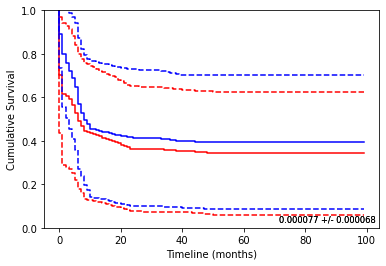

In [50]:
tsi, fsi, ps = km_calculate(results.query(f'Split in {list(F1_accept)}'), 'survival (months)', 'LR_Preds', 'DiedvsAlive')
fig = km_plots(tsi, fsi, ps);

In [51]:
pickle_results['Normal LR'] = {'ROC Curves': roc_curves
                               , 'PR Curves': prec_rec_curves
                               , 'Stats': stats
                               , 'TSI': tsi
                               , 'FSI': fsi
                               , 'Survival_P': ps}


# Pickle Results

In [52]:
with open(f'./Results_Outputs/bare_{save_name}.pickle', 'wb') as pickle_file:

    pickle.dump(pickle_results, pickle_file)

# Filtered Bayesian

In [35]:
thres_results = []

for th in np.arange(30,70,5):

    for i, (idx, row) in enumerate(tqdm(list(results.iterrows())), start=1):

        try:
            perc = np.percentile(row['BLR_Posterior'].std(axis=1), th)
            indx = (row['BLR_Posterior'].std(axis=1) < perc).values#[0]

            #indx_s = np.random.randint(0,len(indx), 100)

            preds = row['BLR_Posterior'].iloc[indx, :].mean(axis=1)
            y_true = row['y_test'].values[indx]

            if len(np.unique(true)) ==1: continue

            thres_results.append({'Threshold': th,
                                'AUC': roc_auc_score(y_true, preds),
                                'Bootstrap':i})
        except IndexError as e:

            print('Index')

        except ValueError as e:
            print(e)
            print(f'Error: {th}')

KeyboardInterrupt: 

In [27]:
thresh_results = pd.DataFrame(thres_results)

In [28]:
thresh_results.groupby('Threshold').mean()

AUC  Bootstrap
Threshold                     
30         0.594305  35.343284
35         0.589444  35.308824
40         0.597705  35.742857
45         0.592263  36.098592
50         0.591830  36.098592
55         0.598015  36.098592
60         0.605415  36.098592
65         0.615054  36.098592

/home/sgcwhitl/miniconda3/envs/pipeline/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/sgcwhitl/miniconda3/envs/pipeline/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/sgcwhitl/miniconda3/envs/pipeline/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:803: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn("No negative samples in y_true, "
/home/sgcwhitl/miniconda3/envs/pipeline/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "
/home/s

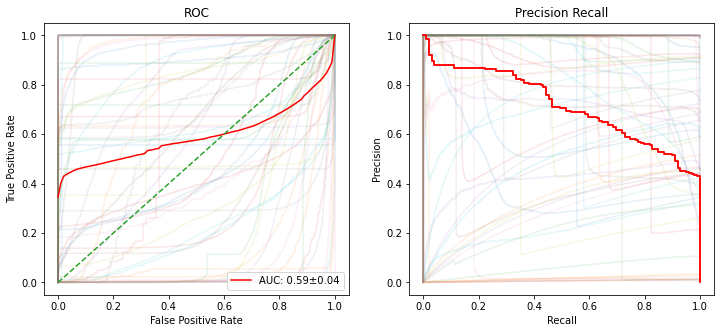

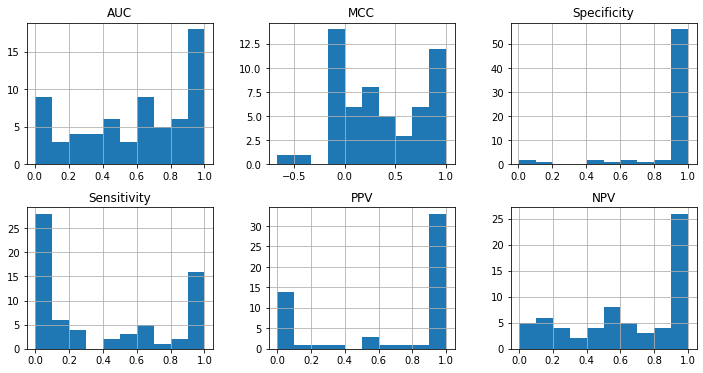

In [48]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (12,5), constrained_layout = True)

stats = {'AUC':[]
        ,'MCC':[]
        ,'Specificity':[]
        ,'Sensitivity':[]
        ,'PPV':[]
        ,'NPV':[]}

roc_curves = []
prec_rec_curves = []

#for idx, row in results.loc[~(F1==0).any(axis=1)].iterrows():
for idx, row in results.iterrows():
    
    # Calculate nth percentile of standard deviations for each prediction
    perc = np.percentile(row['BLR_Posterior'].std(axis=1), 30)

    # Filter based on the percentile value
    indx = np.where(row['BLR_Posterior'].std(axis=1) < perc)[0]

    # Only take predictions and true values for those with the std dev
    # less than that given by the percentile value
    preds = row['BLR_Posterior'].iloc[indx, :].mean(axis=1)
    y_true = row['y_test'].values[indx]

    # Need to check if 0.5 is a suitable value
    predst = np.array([1 if el > 0.5 else 0 for el in preds])

    try:
        fpr, tpr, thresh = roc_curve(y_true, preds);

    except IndexError as e:

        print('index')
        continue
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax1, alpha=0.1)

    roc_curves.append(np.interp(np.linspace(0,1,100), fpr, tpr))

    #ax2.plot(fpr_u, tpr_u, label='unweighted')
    ax1.set_title("ROC")

    prec, recall, _ = precision_recall_curve(y_true, preds)
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax2, alpha=0.1)
    ax2.set_title("Precision Recall")
    prec_rec_curves.append(np.interp(np.linspace(0,1,100), prec, recall))


    cm = confusion_matrix(y_true, predst)
    try:
        tn, fp, fn, tp = cm.flatten()
    except:
        continue

    try:
        stats['AUC'].append(roc_auc_score(y_true, preds))
        stats['Specificity'].append(tn/(tn+fp))
        stats['Sensitivity'].append(tp/(tp+fn))
        stats['PPV'].append(tp/(tp+fp))
        stats['NPV'].append(tn/(tn+fn))
        stats['MCC'].append(((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn)))

    except:
        pass

roc_curves=np.array(roc_curves)
prec_rec_curves=np.array(prec_rec_curves)

#fpr_w, tpr_w, thresh_w = roc_curve(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values));
#auc = roc_auc_score(np.concatenate(results['y_test'].values), np.concatenate(results['LR_preds'].values))
RocCurveDisplay(fpr=np.linspace(0,1,100), tpr=np.nanmean(roc_curves, axis=0)).plot(ax=ax1, color='r', label=f"AUC: {np.mean(stats['AUC']):.2f}±{sem(stats['AUC']):.2f}")
PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')


ax1.plot([0,1],[0,1], ls='--')

if not os.path.exists(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f"):

    os.makedirs(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f")

PrecisionRecallDisplay(recall=np.linspace(0,1,100), precision=np.nanmean(prec_rec_curves, axis=0)).plot(ax=ax2, color='r')
plt.savefig(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f/roc_prec.pdf", bbox_inches='tight')

#pd.DataFrame(stats).hist(figsize=(12,6), layout=(2,3));
#plt.savefig(f"./plots/New/{FN.split('/')[-1][:-7]}/BLR_f/stats.pdf", bbox_inches='tight')

stats_plot(pd.DataFrame(stats))

plt.savefig(f"./plots/{FN.split('/')[-1][:-7]}/BLR_f/stats.pdf", bbox_inches='tight')
print(f" plots saved in ./plots/{FN.split('/')[-1][:-7]}/BLR_f/stats.pdf")
